In [ ]:
pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Embedding, Reshape, Input, concatenate, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
games = pd.read_csv(r'/content/drive/MyDrive/games.csv')
games.columns.values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


array(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home',
       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home',
       'REB_home', 'TEAM_ID_away', 'PTS_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away',
       'HOME_TEAM_WINS'], dtype=object)

In [ ]:
#zmiana ID druzyn do prostych wartosci 0 - 29
team_id = games['HOME_TEAM_ID'].unique()
games = games.replace(team_id, np.arange(0,30,1))
games

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2022-12-22,22200477,Final,0,20,2022,0,126.0,0.484,0.926,...,25.0,46.0,20,117.0,0.478,0.815,0.321,23.0,44.0,1
1,2022-12-22,22200478,Final,1,27,2022,1,120.0,0.488,0.952,...,16.0,40.0,27,112.0,0.561,0.765,0.333,20.0,37.0,1
2,2022-12-21,22200466,Final,2,21,2022,2,114.0,0.482,0.786,...,22.0,37.0,21,106.0,0.470,0.682,0.433,20.0,46.0,1
3,2022-12-21,22200467,Final,3,13,2022,3,113.0,0.441,0.909,...,27.0,49.0,13,93.0,0.392,0.735,0.261,15.0,46.0,1
4,2022-12-21,22200468,Final,4,23,2022,4,108.0,0.429,1.000,...,22.0,47.0,23,110.0,0.500,0.773,0.292,20.0,47.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,Final,4,0,2014,4,93.0,0.419,0.821,...,24.0,50.0,0,87.0,0.366,0.643,0.375,17.0,43.0,1
26647,2014-10-06,11400004,Final,23,27,2014,23,81.0,0.338,0.719,...,18.0,40.0,27,85.0,0.411,0.636,0.267,17.0,47.0,0
26648,2014-10-06,11400005,Final,19,16,2014,19,98.0,0.448,0.682,...,29.0,45.0,16,95.0,0.387,0.659,0.500,19.0,43.0,1
26649,2014-10-05,11400002,Final,18,11,2014,18,99.0,0.440,0.771,...,21.0,30.0,11,94.0,0.469,0.725,0.385,18.0,45.0,1


In [ ]:
def divide_seasons(season_1, season_2, feature ,pd_games = games):
    result_1 = pd_games[pd_games['SEASON'] == season_1]
    result_2 = pd_games[pd_games['SEASON'] == season_2]
    result = pd.concat([result_1, result_2])
    result = result.loc[: , ~result.columns.isin(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'TEAM_ID_home', 'TEAM_ID_away', 'SEASON'])]
    X_result_id = result.loc[: , ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].to_numpy()
    y_result_win = result['HOME_TEAM_WINS'].to_numpy()
    y_result_feat = result[feature].to_numpy()
    return X_result_id, y_result_feat, y_result_win


In [ ]:

#generator do tworzenia wykresow
features = [ 'FG_PCT_away',
       'FT_PCT_away','FG3_PCT_away', 'AST_away', 'REB_away',
]

"""
'PTS_home',
       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home',
       'REB_home','PTS_away',
"""

"\n'PTS_home',\n       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home',\n       'REB_home','PTS_away',\n"

In [ ]:

def generator(lista):
  for number in lista:
    yield number

#gen = generator(features)  #/// odkomentowac do tworzenia 1 wykresu, pozniej zakomentowac


In [ ]:

feature = next(gen)
print(feature)

REB_away


In [ ]:
#zbior treningowy 2017/18 + 2018/19
X_train_id, y_train_feat, y_train_win = divide_seasons(2017, 2018, feature)

#zbior walidacyjny 2019/20   2020/21
X_valid_id, y_valid_feat, y_valid_win = divide_seasons(2019, 2020, feature)       #mniejsza ilosc meczy ze wzgledu na COVID

#zbior testowy - 2021/22 2022/23
X_test_id, y_test_feat, y_test_win  = divide_seasons(2021, 2022, feature)       #roznica w ilosci wynika z niedokonczonego sezonu 2022 (do konca grudnia)

In [ ]:
feature_split = feature.split("_")

if 'PCT' in feature_split:
  activ_func = 'sigmoid'
else:
  activ_func = 'relu'

activ_func

'relu'

In [ ]:
#model_feat - feature

def model_feat_builder(hp, activation_func = activ_func):

  hp_units = hp.Int('units', min_value=10, max_value=100, step=5)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])    #zadajemy liste wartosci ---> stad Choice
  hp_output_dim = hp.Int('output_dim', min_value = 1, max_value = 10, step = 1)

  input_embedding_feat = Input(shape = (2,))
  embedding_feat = Embedding(input_dim=30, output_dim = hp_output_dim, input_length=2)(input_embedding_feat)
  embedding_feat = Dense(units = hp_units)(embedding_feat)
  #embedding_feat = Flatten()(embedding_feat)
  output_feat = Dense(1, activation = activation_func)(embedding_feat)
  model_feat = Model(input_embedding_feat, output_feat)

  model_feat.compile(optimizer = Adam(learning_rate = hp_learning_rate), loss = 'mse')

  return model_feat


In [ ]:
"""
!rm -r /content/Val_loss_model_feat_builder
USUWANIE ISTNIEJACEGO KATALOGU Z REPOZYTORIUM
"""

'\n!rm -r /content/Val_loss_model_feat_builder\nUSUWANIE ISTNIEJACEGO KATALOGU Z REPOZYTORIUM\n'

In [ ]:
#Do determinacji wielkosci min_delta w EarlyStopping


input_embedding_feat = Input(shape = (2,))
embedding_feat = Embedding(input_dim=30, output_dim = 2, input_length=2)(input_embedding_feat)
embedding_feat = Dense(units = 10)(embedding_feat)
#embedding_feat = Flatten()(embedding_feat)
embedding_feat = Dropout(0.2)(embedding_feat)
output_feat = Dense(1, activation = activ_func)(embedding_feat)
model_temp = Model(input_embedding_feat, output_feat)

model_temp.compile(optimizer = 'adam', loss = 'mse')
model_temp.fit(X_train_id, y_train_feat, validation_data = (X_valid_id, y_valid_feat), epochs = 20)

delta = float(input("Wprowadz min_detla: "))

Epoch 1/20
87/87 [==============================] - 2s 15ms/step - loss: 1929.2393 - val_loss: 1925.3544
Epoch 2/20
87/87 [==============================] - 1s 8ms/step - loss: 1838.0732 - val_loss: 1793.3932
Epoch 3/20
87/87 [==============================] - 1s 7ms/step - loss: 1658.7257 - val_loss: 1559.4967
Epoch 4/20
87/87 [==============================] - 1s 7ms/step - loss: 1377.6420 - val_loss: 1227.0177
Epoch 5/20
87/87 [==============================] - 1s 8ms/step - loss: 1021.1646 - val_loss: 843.1588
Epoch 6/20
87/87 [==============================] - 1s 6ms/step - loss: 655.1550 - val_loss: 489.2324
Epoch 7/20
87/87 [==============================] - 1s 6ms/step - loss: 357.6104 - val_loss: 238.4954
Epoch 8/20
87/87 [==============================] - 0s 6ms/step - loss: 185.9883 - val_loss: 109.1984
Epoch 9/20
87/87 [==============================] - 1s 8ms/step - loss: 114.9037 - val_loss: 62.3557
Epoch 10/20
87/87 [==============================] - 0s 6ms/step - loss: 

In [ ]:
#tworzenie obiektu Tunera
dir = 'Val_loss_feat_model_' + feature

tuner_feat = kt.Hyperband(model_feat_builder,
                     objective='val_loss',
                     max_epochs = 21,     #factor = 3 domyslnie wiec 21 aby kolejne iteracje byly po 7 epochs
                     directory= dir,
                     project_name='Model_feat')

#tworzenie obiektu Callback - early stopping do zatrzymania wczesniej programu

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', min_delta = delta , patience = 4)   #jezeli val_loss w przeciagu 3 epok nie spadnie poniżej aktualnej w.min. to koniec

In [ ]:
#Szukanie najlepszych parametrow
tuner_feat.search(X_train_id, y_train_feat, epochs=50, validation_data = (X_valid_id, y_valid_feat), callbacks = [stop_early])

# Get the optimal hyperparameters
best_hps_feat = tuner_feat.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 00m 06s]
val_loss: 42.757564544677734

Best val_loss So Far: 42.663299560546875
Total elapsed time: 00h 03m 20s


In [ ]:
print(f"Cecha: {feature}\nNajlepsza ilosc neuronow w warstwie: {best_hps_feat.get('units')} \nNajlepszy learning_rate modelu: {best_hps_feat.get('learning_rate')} \nNajlepsza ilosc output_dim: {best_hps_feat.get('output_dim')}")

Cecha: REB_away
Najlepsza ilosc neuronow w warstwie: 90 
Najlepszy learning_rate modelu: 0.01 
Najlepsza ilosc output_dim: 3


In [ ]:
model_feat = tuner_feat.hypermodel.build(best_hps_feat)
r_feat = model_feat.fit(X_train_id, y_train_feat, epochs=50, validation_data = (X_valid_id, y_valid_feat))

val_loss_per_epoch = r_feat.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print(f"Najlepsza iteracja: {best_epoch}")

Epoch 1/50
87/87 [==============================] - 2s 16ms/step - loss: 546.4483 - val_loss: 43.8394
Epoch 2/50
87/87 [==============================] - 0s 6ms/step - loss: 42.9459 - val_loss: 43.3872
Epoch 3/50
87/87 [==============================] - 1s 9ms/step - loss: 42.7778 - val_loss: 43.1175
Epoch 4/50
87/87 [==============================] - 1s 7ms/step - loss: 43.2979 - val_loss: 45.1580
Epoch 5/50
87/87 [==============================] - 1s 9ms/step - loss: 43.1743 - val_loss: 43.5573
Epoch 6/50
87/87 [==============================] - 1s 7ms/step - loss: 43.0151 - val_loss: 42.9816
Epoch 7/50
87/87 [==============================] - 1s 8ms/step - loss: 43.0278 - val_loss: 52.1855
Epoch 8/50
87/87 [==============================] - 1s 9ms/step - loss: 43.4905 - val_loss: 42.7077
Epoch 9/50
87/87 [==============================] - 1s 9ms/step - loss: 42.8519 - val_loss: 42.6713
Epoch 10/50
87/87 [==============================] - 1s 9ms/step - loss: 42.9422 - val_loss: 43.50

<Figure size 640x480 with 0 Axes>

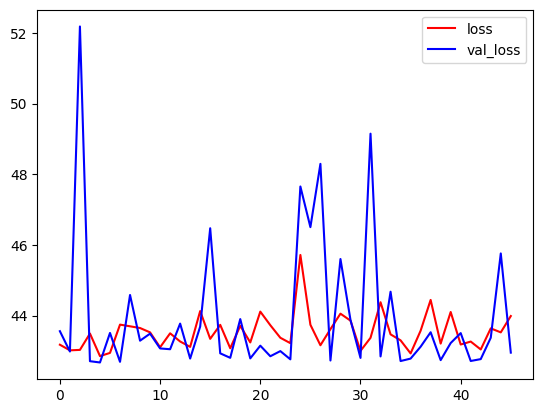

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(r_feat.history['loss'][4:], color = 'red', label = 'loss')
plt.plot(r_feat.history['val_loss'][4:], color = 'blue', label = 'val_loss')
plt.legend()
plt.figure()

In [ ]:
#freeze wag model_feat

def model_win_builder(hp, model_feat = model_feat):

  for layer in model_feat.layers:
      layer.trainable=False

  hp_units_1 = hp.Int('units_1', min_value=4, max_value=64, step=4)
  hp_units_2 = hp.Int('units_2', min_value=4, max_value=64, step=4)
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])    #zadajemy liste wartosci ---> stad Choice
  hp_output_dim = hp.Int('output_dim', min_value = 1, max_value = 10, step = 1)


  #model - win
  input_embedding_win = Input(shape = (2,))
  embedding_win = Embedding(input_dim=30, output_dim = hp_output_dim, input_length=2)(input_embedding_win)
  #embedding_win = Flatten()(embedding_win)
  print(embedding_win.shape)


  merged = concatenate([model_feat.output, embedding_win])

  #zmienic ilosc neuronow
  merged = Dense(hp_units_1, activation = 'relu', name='dense_layer_1')(merged)   #nazwy zmodyfikowane z uwagi na blad nazw w tuner.search
  merged = Dense(hp_units_2, activation = 'relu', name='dense_layer_2')(merged)
  ###
  merged = Flatten()(merged)
  merged = Dropout(0.2)(merged)
  output = Dense(1, activation = 'sigmoid')(merged)

  model_win = Model(inputs = [input_embedding_win, model_feat.input], outputs = output)
  model_win.compile(optimizer = Adam(learning_rate = hp_learning_rate), loss = 'binary_crossentropy', metrics = ['accuracy'])
  return model_win

In [ ]:

"""
!rm -r /content/val_acc_model_win_builder
DO USUWANIA ISTNIEJACEGO PLIKU Z HP
"""

'\n!rm -r /content/val_acc_model_win_builder\nDO USUWANIA ISTNIEJACEGO PLIKU Z HP\n'

In [ ]:
dir = 'Val_acc_win_model_' + feature

tuner_win = kt.Hyperband(model_win_builder,
                     objective='val_accuracy',
                     max_epochs = 21,
                     directory= dir,
                     project_name='model_win',
                      overwrite = True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', min_delta= 1, verbose= True, patience = 4)

(None, 2, 1)


In [ ]:
#Szukanie najlepszych hp

tuner_win.search([X_train_id, X_train_id], y_train_win, epochs= 50, validation_data = ([X_valid_id, X_valid_id], y_valid_win), callbacks = [early_stop])

#najlepsze parametry
best_hps_win = tuner_win.get_best_hyperparameters(num_trials=3)[0]

Trial 30 Complete [00h 00m 09s]
val_accuracy: 0.563052237033844

Best val_accuracy So Far: 0.563052237033844
Total elapsed time: 00h 04m 03s


In [ ]:

print(f"Najlepsza ilosc neuronow w warstwie Dense_1: {best_hps_win.get('units_1')} \nNajlepsza ilosc neuronow w warstwie Dense_2: {best_hps_win.get('units_2')}\nNajlepszy learning_rate modelu: {best_hps_win.get('learning_rate')}\nNajlepsza ilosc output_dim: {best_hps_feat.get('output_dim')}")

Najlepsza ilosc neuronow w warstwie Dense_1: 52 
Najlepsza ilosc neuronow w warstwie Dense_2: 20
Najlepszy learning_rate modelu: 0.01
Najlepsza ilosc output_dim: 3


In [ ]:
hypermodel_win_1 = tuner_win.hypermodel.build(best_hps_win)

r_win = hypermodel_win_1.fit([X_train_id, X_train_id], y_train_win, epochs= 50, validation_data = ([X_valid_id, X_valid_id], y_valid_win))
val_acc_per_epoch = r_win.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print(f"Najlepsza iteracja: {best_epoch}")

(None, 2, 10)
Epoch 1/50
87/87 [==============================] - 4s 31ms/step - loss: 1.2342 - accuracy: 0.4924 - val_loss: 0.6895 - val_accuracy: 0.5410
Epoch 2/50
87/87 [==============================] - 1s 10ms/step - loss: 0.7705 - accuracy: 0.5232 - val_loss: 0.7046 - val_accuracy: 0.5410
Epoch 3/50
87/87 [==============================] - 1s 8ms/step - loss: 0.7079 - accuracy: 0.5431 - val_loss: 0.7016 - val_accuracy: 0.5410
Epoch 4/50
87/87 [==============================] - 1s 10ms/step - loss: 0.6596 - accuracy: 0.6105 - val_loss: 0.6974 - val_accuracy: 0.5530
Epoch 5/50
87/87 [==============================] - 1s 10ms/step - loss: 0.6347 - accuracy: 0.6435 - val_loss: 0.7213 - val_accuracy: 0.5570
Epoch 6/50
87/87 [==============================] - 1s 9ms/step - loss: 0.6269 - accuracy: 0.6471 - val_loss: 0.7548 - val_accuracy: 0.5562
Epoch 7/50
87/87 [==============================] - 1s 8ms/step - loss: 0.6359 - accuracy: 0.6380 - val_loss: 0.7298 - val_accuracy: 0.5526
Ep

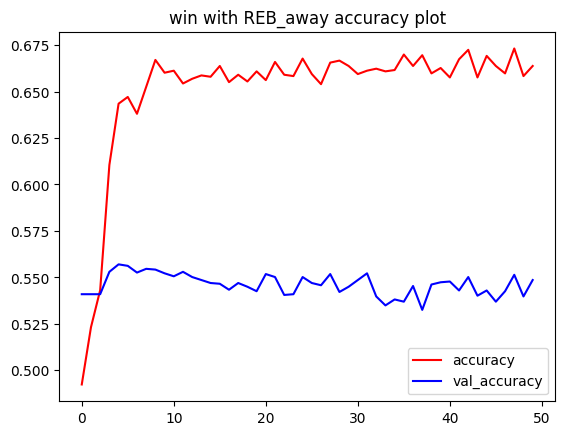

In [ ]:
plt.plot(r_win.history['accuracy'], label = 'accuracy', color = 'red')
plt.plot(r_win.history['val_accuracy'], label = 'val_accuracy', color = 'blue')
plt.title('win with ' + feature + ' accuracy plot')
plt.legend()


filename_acc = '/content/win_accuracy_plot-' + feature + '.png'
plt.savefig(filename_acc, format = 'png')


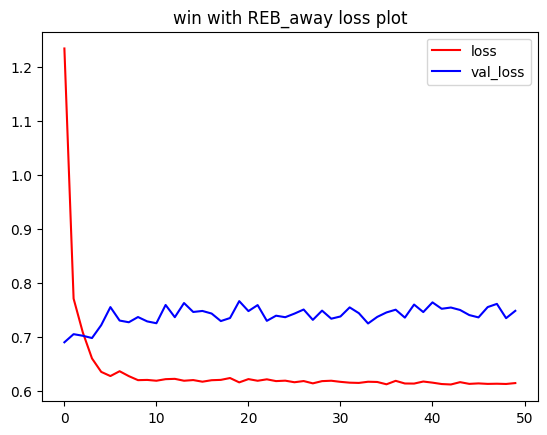

In [ ]:
plt.plot(r_win.history['loss'], label = 'loss', color = 'red')
plt.plot(r_win.history['val_loss'], label = 'val_loss', color = 'blue')
plt.title('win with ' + feature + ' loss plot')
plt.legend()


filename_loss = '/content/win_loss_plot-' + feature + '.png'
plt.savefig(filename_loss, format = 'png')


In [ ]:


from google.colab import files

files.download(filename_acc)
files.download(filename_loss)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#SKONCZONE NA PTS_AWAY